In [68]:
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import networkx as nx

In [69]:
# Intentar leer el archivo
file_path = os.path.join(os.getcwd(), "gdb1.dat")
with open(file_path, "r") as file:
    texto = file.read()

# Expresión regular para extraer las aristas requeridas
arcos = {
    (int(n1), int(n2)): [int(c), int(d)]
    for n1, n2, c, d in re.findall(r"\(\s*(\d+),\s*(\d+)\)\s+coste\s+(\d+)\s+demanda\s+(\d+)", texto)
}

# Expresión regular para capturar el número después de "DEPOSITO :"
match = re.search(r"DEPOSITO\s*:\s*(\d+)", texto)
depot=int(match.groups()[0])

# Expresión regular para capturar el número después de "DEPOSITO :"
match1 = re.search(r"VEHICULOS\s*:\s*(\d+)", texto)
veh=int(match1.groups()[0])

# Expresión regular para capturar el número después de "DEPOSITO :"
match2 = re.search(r"CAPACIDAD\s*:\s*(\d+)", texto)
veh_cap=int(match2.groups()[0])

print("depot: ", depot)
print("# veh: ",veh)
print("cap veh: ",veh_cap)

depot:  1
# veh:  5
cap veh:  5


In [70]:
# Crear un grafo dirigido o no dirigido según el problema
G = nx.Graph()  # Usa nx.DiGraph() si el grafo es dirigido

# Agregar nodos y aristas con atributos
for (n1, n2), (coste, demanda) in arcos.items():
    G.add_edge(n1, n2, weight=coste, demanda=demanda)

nodos=list(G.nodes())
print(nodos)
nodos.remove(depot)
print(nodos)



[1, 2, 4, 7, 10, 12, 3, 9, 5, 6, 11, 8]
[2, 4, 7, 10, 12, 3, 9, 5, 6, 11, 8]


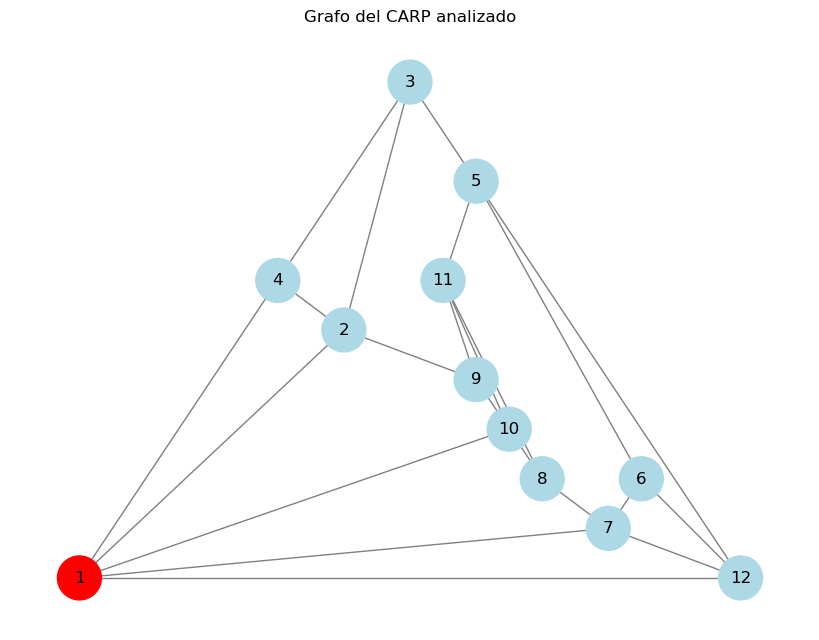

In [71]:
seed=8
# Dibujar el grafo
pos = nx.planar_layout(G)  # Posiciones de los nodos
edge_labels = {(n1, n2): f"C: {coste}, D: {demanda}" for (n1, n2), (coste, demanda) in aristas_req.items()}

plt.figure(figsize=(8, 6))
node_colors = ["red" if node == depot else "lightblue" for node in G.nodes()]
nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=1000, edge_color='gray', font_size=12)
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.title("Grafo del CARP analizado")
plt.show()

In [ ]:
data=list(G.edges(data=True))
print(data[0])
print(data[0][2]["weight"])


(1, 2, {'weight': 13, 'demanda': 1})
13
